# **Cuaderno 03: Vía Visual - Mapeo de Grafema -> Embedding Auditivo**

### **Objetivo del Proyecto: Conciencia Fonológica Computacional**
Este proyecto busca emular el proceso cognitivo de la **conciencia fonológica**: la habilidad de asociar un símbolo visual (grafema, ej. la letra 'a') con su correspondiente unidad de sonido (fonema, ej. el sonido /a/).

Para lograrlo, entrenamos una **Vía Visual** capaz de "imaginar" o predecir la representación neuronal de un sonido (un *embedding* de `wav2vec2`) a partir de la simple imagen de su letra.

### **Flujo de Trabajo de este Notebook:**
1.  **Instalación y Configuración**: Instalar `cornet` y definir los parámetros globales del experimento.
2.  **Pre-procesamiento de Imágenes**: Tarea única para redimensionar las imágenes de grafemas a un tamaño óptimo (64x64) y guardarlas. Esto acelera drásticamente el entrenamiento al evitar el redimensionado repetitivo.
3.  **Definición de Modelos y Dataset**:
    * `GraphemeDataset`: Carga pares de imagen-embedding.
    * `PhonemeCNN`: La arquitectura del clasificador auditivo (nuestro "experto").
    * `VisualToAuditoryModel`: El modelo principal que aprende el mapeo (CORNet-Z + Decodificador LSTM).
4.  **Entrenamiento con Pérdida Perceptual**: El núcleo del experimento. Se explica en detalle cómo usamos el clasificador auditivo congelado como una función de pérdida para guiar el entrenamiento de la vía visual.
5.  **Análisis de Resultados**:
    * Visualización de las curvas de aprendizaje.
    * Generación de un gráfico t-SNE para comparar cualitativamente los embeddings reales vs. los predichos.
    * Evaluación cuantitativa final: cálculo de métricas (Accuracy, Precisión, etc.) y visualización de matrices de confusión y heatmaps de logits para validar el éxito del mapeo.
6.  **Guardado de Artefactos**: Todos los resultados (modelos, figuras y tablas de métricas) se guardan sistemáticamente.


---
### **Paso 1: Instalación y Configuración Global**
En esta sección, instalamos las dependencias y definimos todos los parámetros y rutas que se usarán a lo largo del notebook. Establecer estos valores en un solo lugar facilita la experimentación y la reproducibilidad.

In [37]:
%pip install cornet --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from collections import OrderedDict
from cornet.cornet_z import CORnet_Z

import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

# --- Parámetros Globales del Experimento ---
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "cornetZ_lstm_decoder_perceptual_v2"
EPOCHS = 100
BATCH_SIZE = 512
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1
IMAGE_SIZE = 64 # Usaremos imágenes de 64x64, óptimo para grafemas

# --- Rutas de Archivos ---
project_root = Path.cwd().parent
model_dir = project_root / "results/trained_models"
figure_dir = project_root / "results/figures"
results_dir = project_root / "results/tables"

# Crear directorios si no existen
model_dir.mkdir(parents=True, exist_ok=True)
figure_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# --- Diccionarios para almacenar resultados ---
results_visual = {}
evaluation_metrics = []

Note: you may need to restart the kernel to use updated packages.


### **Paso 2: Pre-procesamiento de Imágenes (Tarea Única)**
El cuello de botella de rendimiento en el entrenamiento de redes de visión suele ser la carga y transformación de datos. Para evitar redimensionar cada imagen en cada una de las 50 épocas (una tarea muy costosa para la CPU), realizamos este trabajo pesado **una sola vez**.

La siguiente celda leerá todas las imágenes de grafemas, las redimensionará al tamaño definido (`IMAGE_SIZE`) y las guardará en una nueva carpeta. El bucle de entrenamiento posterior leerá directamente de esta carpeta, haciendo el proceso mucho más rápido y eficiente.


In [38]:
# --- Celda de Pre-procesamiento para Redimensionar Imágenes ---
# Este bloque se ejecuta UNA SOLA VEZ para crear versiones ya redimensionadas
# de las imágenes, acelerando drásticamente el entrenamiento.

print("Iniciando el pre-procesamiento de imágenes...")

resize_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
])

for lang in LANGUAGES:
    source_image_dir = project_root / f"data/02_processed/grapheme_images/{lang}"
    target_image_dir = project_root / f"data/02_processed/grapheme_images_resized_{IMAGE_SIZE}/{lang}"
    
    grapheme_folders = [d for d in source_image_dir.iterdir() if d.is_dir()]
    
    print(f"Procesando {len(grapheme_folders)} grafemas para '{lang.upper()}'...")
    
    for grapheme_dir in tqdm(grapheme_folders, desc=f'Procesando {lang.upper()}'):
        target_grapheme_path = target_image_dir / grapheme_dir.name
        target_grapheme_path.mkdir(parents=True, exist_ok=True)
        
        for img_path in grapheme_dir.glob("*.png"):
            image = Image.open(img_path).convert("RGB")
            resized_image = resize_transform(image)
            target_path = target_grapheme_path / img_path.name
            resized_image.save(target_path)
            
print(f"\nPre-procesamiento completado. Las imágenes de {IMAGE_SIZE}x{IMAGE_SIZE} están guardadas.")

Iniciando el pre-procesamiento de imágenes...
Procesando 25 grafemas para 'ES'...


Procesando ES:   0%|          | 0/25 [00:00<?, ?it/s]

Procesando 25 grafemas para 'EN'...


Procesando EN:   0%|          | 0/25 [00:00<?, ?it/s]


Pre-procesamiento completado. Las imágenes de 64x64 están guardadas.


---
### **Paso 3: Definición de Modelos y Clases de Datos**

Aquí se definen todas las clases necesarias para el experimento.

* **`GraphemeDataset`**: Es nuestro cargador de datos personalizado. Se encarga de encontrar los grafemas que existen tanto en el dominio visual (imágenes) como en el auditivo (embeddings .npy) y de cargar los pares correspondientes.
* **`PhonemeCNN`**: Es la arquitectura de nuestro clasificador auditivo, el "experto" que usaremos en la pérdida perceptual. Su definición debe ser idéntica a la utilizada en su entrenamiento original.
* **`VisualToAuditoryModel`**: Es el modelo principal que queremos entrenar. Utiliza una red **CORNet-Z** pre-entrenada (cuyos pesos se congelan) como extractor de características visuales, y un **Decodificador LSTM** entrenable para generar la secuencia de embeddings auditivos a partir de la representación visual.

In [39]:
# --- Definiciones de Clases ---

class GraphemeDataset(Dataset):
    """Carga pares de (imagen de grafema, secuencia de embedding auditivo)."""
    def __init__(self, image_dir, embedding_dir, transform=None):
        self.transform = transform
        self.embedding_dir = embedding_dir
        
        image_graphemes = {p.parent.name for p in image_dir.glob("*/*.png")}
        embedding_graphemes = {p.stem for p in embedding_dir.glob("*.npy")}
        
        common_graphemes = sorted(list(image_graphemes.intersection(embedding_graphemes)))
        self.labels = [g for g in common_graphemes if len(g) == 1] # Nos aseguramos de usar solo grafemas de 1 letra
        
        self.image_paths = []
        for grapheme in self.labels:
            self.image_paths.extend(list((image_dir / grapheme).glob("*.png")))
        
        print(f"Dataset creado con {len(self.image_paths)} imágenes de {len(self.labels)} grafemas comunes.")
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = img_path.parent.name
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        embedding_path = self.embedding_dir / f"{label}.npy"
        embedding = torch.tensor(np.load(embedding_path), dtype=torch.float32)
        
        return image, embedding, label

class PhonemeCNN(nn.Module):
    """Arquitectura del clasificador auditivo. Debe ser idéntica al modelo entrenado."""
    def __init__(self, input_size=1024, num_classes=23):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class VisualToAuditoryModel(nn.Module):
    """Modelo híbrido que mapea una imagen a una secuencia de embeddings."""
    def __init__(self, target_embedding_dim=1024, lstm_hidden_dim=512, dropout=0.3):
        super().__init__()
        # Extractor de características visuales (congelado)
        self.cornet = CORnet_Z()
        url = 'https://s3.amazonaws.com/cornet-models/cornet_z-5c427c9c.pth'
        ckpt_data = torch.hub.load_state_dict_from_url(url, map_location="cpu")
        original_state_dict = ckpt_data['state_dict']
        new_state_dict = OrderedDict()
        for k, v in original_state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_state_dict[name] = v
        self.cornet.load_state_dict(new_state_dict)
        
        cornet_output_dim = self.cornet.decoder.linear.in_features
        self.cornet.decoder.linear = nn.Identity() # Quitamos la capa final de clasificación
        for param in self.cornet.parameters():
            param.requires_grad = False
        
        # Proyector y Decodificador (entrenables)
        self.projector = nn.Sequential(nn.Linear(cornet_output_dim, lstm_hidden_dim), nn.BatchNorm1d(lstm_hidden_dim), nn.ReLU(), nn.Dropout(dropout))
        self.decoder_lstm = nn.LSTM(input_size=lstm_hidden_dim, hidden_size=lstm_hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(lstm_hidden_dim, target_embedding_dim)

    def forward(self, image, target_sequence):
        seq_len = target_sequence.shape[1]
        cornet_features = self.cornet(image)
        projected_features = self.projector(cornet_features)
        
        # Usamos la característica visual como estado inicial y como entrada en cada paso
        h0 = projected_features.unsqueeze(0).repeat(self.decoder_lstm.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)
        decoder_input = projected_features.unsqueeze(1).repeat(1, seq_len, 1)
        
        lstm_output, _ = self.decoder_lstm(decoder_input, (h0, c0))
        predicted_sequence = self.output_layer(lstm_output)
        return predicted_sequence

# --- Funciones de Ayuda para el DataLoader ---
def collate_fn_visual(batch):
    images = [item[0] for item in batch]
    embeddings = [item[1] for item in batch]
    labels = [item[2] for item in batch]
    images_tensor = torch.stack(images)
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    return images_tensor, padded_embeddings, labels

def collate_fn_visual_with_labels(batch):
    images = [item[0] for item in batch]
    embeddings = [item[1] for item in batch]
    labels = [item[2] for item in batch]
    images_tensor = torch.stack(images)
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    return images_tensor, padded_embeddings, labels

---
### **Paso 4: Entrenamiento con Pérdida Perceptual**

Este es el paso más importante. En lugar de usar una pérdida simple como el Error Cuadrático Medio (MSE) entre los embeddings, empleamos una **Pérdida Perceptual**.

**¿Cómo funciona?**

1.  Cargamos nuestro clasificador auditivo (`PhonemeCNN`) que ya fue entrenado y **congelamos sus pesos**. Este modelo actúa como un "experto" que sabe qué características de un embedding son importantes para identificar un fonema.
2.  Durante el entrenamiento de la vía visual, le pasamos tanto los embeddings **reales** (de `wav2vec2`) como los **predichos** (por `VisualToAuditoryModel`) a este clasificador experto.
3.  Calculamos la pérdida (MSE) no sobre los embeddings en sí, sino sobre **las salidas del clasificador (logits)**.

Al hacer esto, el objetivo del entrenamiento deja de ser "crea un embedding idéntico" y se convierte en "crea un embedding que el experto identifique de la misma manera que el real". Esto alinea el entrenamiento de la vía visual con el objetivo final de la clasificación fonológica, produciendo resultados mucho más robustos.


In [40]:
# --- Bucle Principal de Entrenamiento con Pérdida Perceptual ---

# La transformación ahora es muy simple gracias al pre-procesamiento
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
loss_fn = nn.MSELoss() # Usaremos MSE entre los LOGITS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lang in LANGUAGES:
    print(f"\n{'='*20} PROCESANDO IDIOMA: {lang.upper()} {'='*20}")
    
    image_dir = project_root / f"data/02_processed/grapheme_images_resized_{IMAGE_SIZE}/{lang}"
    embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    
    # Cargar el clasificador auditivo "experto"
    auditory_model_path = model_dir / f"{lang}_auditory_cnn1d_comparative.pth"
    if not auditory_model_path.exists():
        print(f"Modelo auditivo para '{lang}' no encontrado. Saltando...")
        continue
    
    all_auditory_labels = sorted([p.stem for p in embedding_dir.glob("*.npy")])
    num_total_auditory_classes = len(all_auditory_labels)
    
    auditory_cnn = PhonemeCNN(num_classes=num_total_auditory_classes).to(device)
    auditory_cnn.load_state_dict(torch.load(auditory_model_path, map_location=device))
    auditory_cnn.eval()
    for param in auditory_cnn.parameters():
        param.requires_grad = False
    
    full_dataset = GraphemeDataset(image_dir, embedding_dir, transform=transform_train)
    val_size = int(VALIDATION_SPLIT * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_visual, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual, num_workers=4, pin_memory=True)

    model = VisualToAuditoryModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = {'train_loss': [], 'val_loss': [], 'val_euclidean_dist': []}

    print(f"Entrenando modelo para '{lang}' con {len(train_dataset)} imágenes (Pérdida Perceptual)...")
    for epoch in tqdm(range(EPOCHS), desc=f'Training {lang.upper()}'):
        model.train()
        running_loss = 0.0
        for images, target_embeddings, _ in train_loader:
            images, target_embeddings = images.to(device), target_embeddings.to(device)
            optimizer.zero_grad()
            
            predicted_embeddings = model(images, target_embeddings)
            
            logits_from_real = auditory_cnn(target_embeddings)
            logits_from_predicted = auditory_cnn(predicted_embeddings)
            loss = loss_fn(logits_from_predicted, logits_from_real)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        history['train_loss'].append(running_loss / len(train_loader))

        model.eval()
        running_val_loss, running_distance = 0.0, 0.0
        with torch.no_grad():
            for images, target_embeddings, _ in val_loader:
                images, target_embeddings = images.to(device), target_embeddings.to(device)
                predicted_embeddings = model(images, target_embeddings)
                
                logits_from_real = auditory_cnn(target_embeddings)
                logits_from_predicted = auditory_cnn(predicted_embeddings)
                loss = loss_fn(logits_from_predicted, logits_from_real)
                
                running_val_loss += loss.item()
                dist = F.pairwise_distance(predicted_embeddings.mean(dim=1), target_embeddings.mean(dim=1), p=2).mean()
                running_distance += dist.item()
                
        history['val_loss'].append(running_val_loss / len(val_loader))
        history['val_euclidean_dist'].append(running_distance / len(val_loader))
        
    print(f"Epoch [{EPOCHS}], Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Euclidean Dist: {history['val_euclidean_dist'][-1]:.4f}")
    results_visual[lang] = {'history': history, 'model': model}
    
print(f"\n{'='*20} PROCESO COMPLETADO {'='*20}")


==================== PROCESANDO IDIOMA: ES ====================
Dataset creado con 1250 imágenes de 25 grafemas comunes.
Entrenando modelo para 'es' con 1125 imágenes (Pérdida Perceptual)...


Training ES:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [100], Train Loss: 51.6788, Val Loss: 173.3327, Val Euclidean Dist: 4.2469

==================== PROCESANDO IDIOMA: EN ====================
Dataset creado con 1250 imágenes de 25 grafemas comunes.
Entrenando modelo para 'en' con 1125 imágenes (Pérdida Perceptual)...


Training EN:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [100], Train Loss: 30.3017, Val Loss: 58.3105, Val Euclidean Dist: 4.6867

==================== PROCESO COMPLETADO ====================


---
### **Paso 5: Análisis de Resultados del Entrenamiento**

Una vez finalizado el entrenamiento, visualizamos las curvas de aprendizaje para diagnosticar si hubo sobreajuste y verificar que el modelo convergió correctamente. Finalmente, guardamos los modelos entrenados para su uso en la evaluación final.


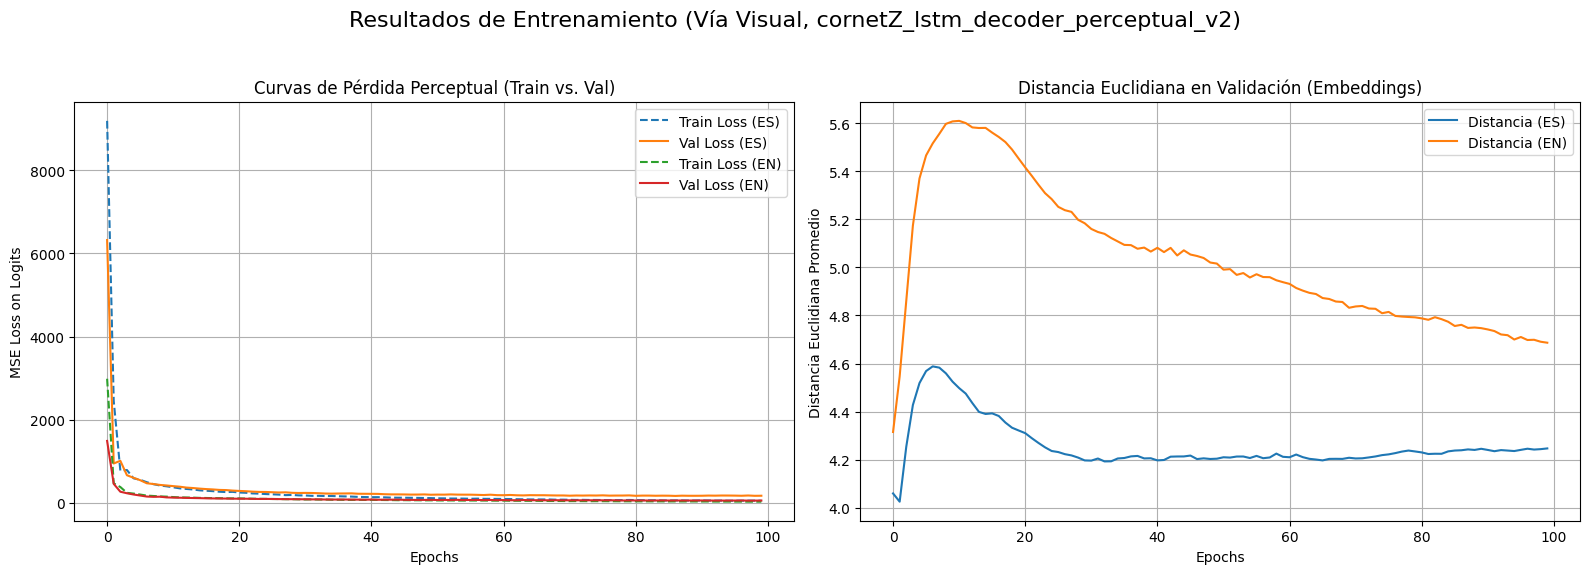

Curvas de aprendizaje guardadas en: /home/daniel/Proyectos/phonological-awareness/results/figures/visual_cornetZ_lstm_decoder_perceptual_v2_learning_curves.png
Modelo para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_visual_cornetZ_lstm_decoder_perceptual_v2.pth
Modelo para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_visual_cornetZ_lstm_decoder_perceptual_v2.pth


In [41]:
# --- Guardar Curvas de Aprendizaje y Modelos ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for lang in LANGUAGES:
    if lang in results_visual:
        ax1.plot(results_visual[lang]['history']['train_loss'], label=f'Train Loss ({lang.upper()})', linestyle='--')
        ax1.plot(results_visual[lang]['history']['val_loss'], label=f'Val Loss ({lang.upper()})')
ax1.set_title('Curvas de Pérdida Perceptual (Train vs. Val)')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('MSE Loss on Logits'); ax1.legend(); ax1.grid(True)

for lang in LANGUAGES:
    if lang in results_visual:
        ax2.plot(results_visual[lang]['history']['val_euclidean_dist'], label=f'Distancia ({lang.upper()})')
ax2.set_title('Distancia Euclidiana en Validación (Embeddings)')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Distancia Euclidiana Promedio'); ax2.legend(); ax2.grid(True)

fig.suptitle(f'Resultados de Entrenamiento (Vía Visual, {MODEL_ARCHITECTURE})', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
learning_curves_path = figure_dir / f"visual_{MODEL_ARCHITECTURE}_learning_curves.png"
plt.savefig(learning_curves_path)
plt.show()
print(f"Curvas de aprendizaje guardadas en: {learning_curves_path}")

# --- Guardar los modelos entrenados ---
for lang in LANGUAGES:
    if lang in results_visual:
        model_visual = results_visual[lang]['model']
        model_visual_path = model_dir / f"{lang}_visual_{MODEL_ARCHITECTURE}.pth"
        torch.save(model_visual.state_dict(), model_visual_path)
        print(f"Modelo para '{lang}' guardado en: {model_visual_path}")

---
### **Paso 6: Evaluación Cualitativa - Visualización t-SNE**

El t-SNE es una técnica de reducción de dimensionalidad que nos permite visualizar los embeddings de alta dimensión (1024D) en un gráfico 2D.

Este gráfico es clave para entender cualitativamente nuestro resultado. Si el entrenamiento fue exitoso, los puntos correspondientes a los **embeddings reales (Audio Real)** y los **predichos (Visual Predicho)** para un mismo grafema deberían agruparse y superponerse, indicando que nuestro modelo visual genera representaciones estructuralmente muy similares a las reales.


Preparando datos para la visualización t-SNE comparativa...
Dataset creado con 1250 imágenes de 25 grafemas comunes.
Dataset creado con 1250 imágenes de 25 grafemas comunes.

Calculando proyección t-SNE... Esto puede tardar.


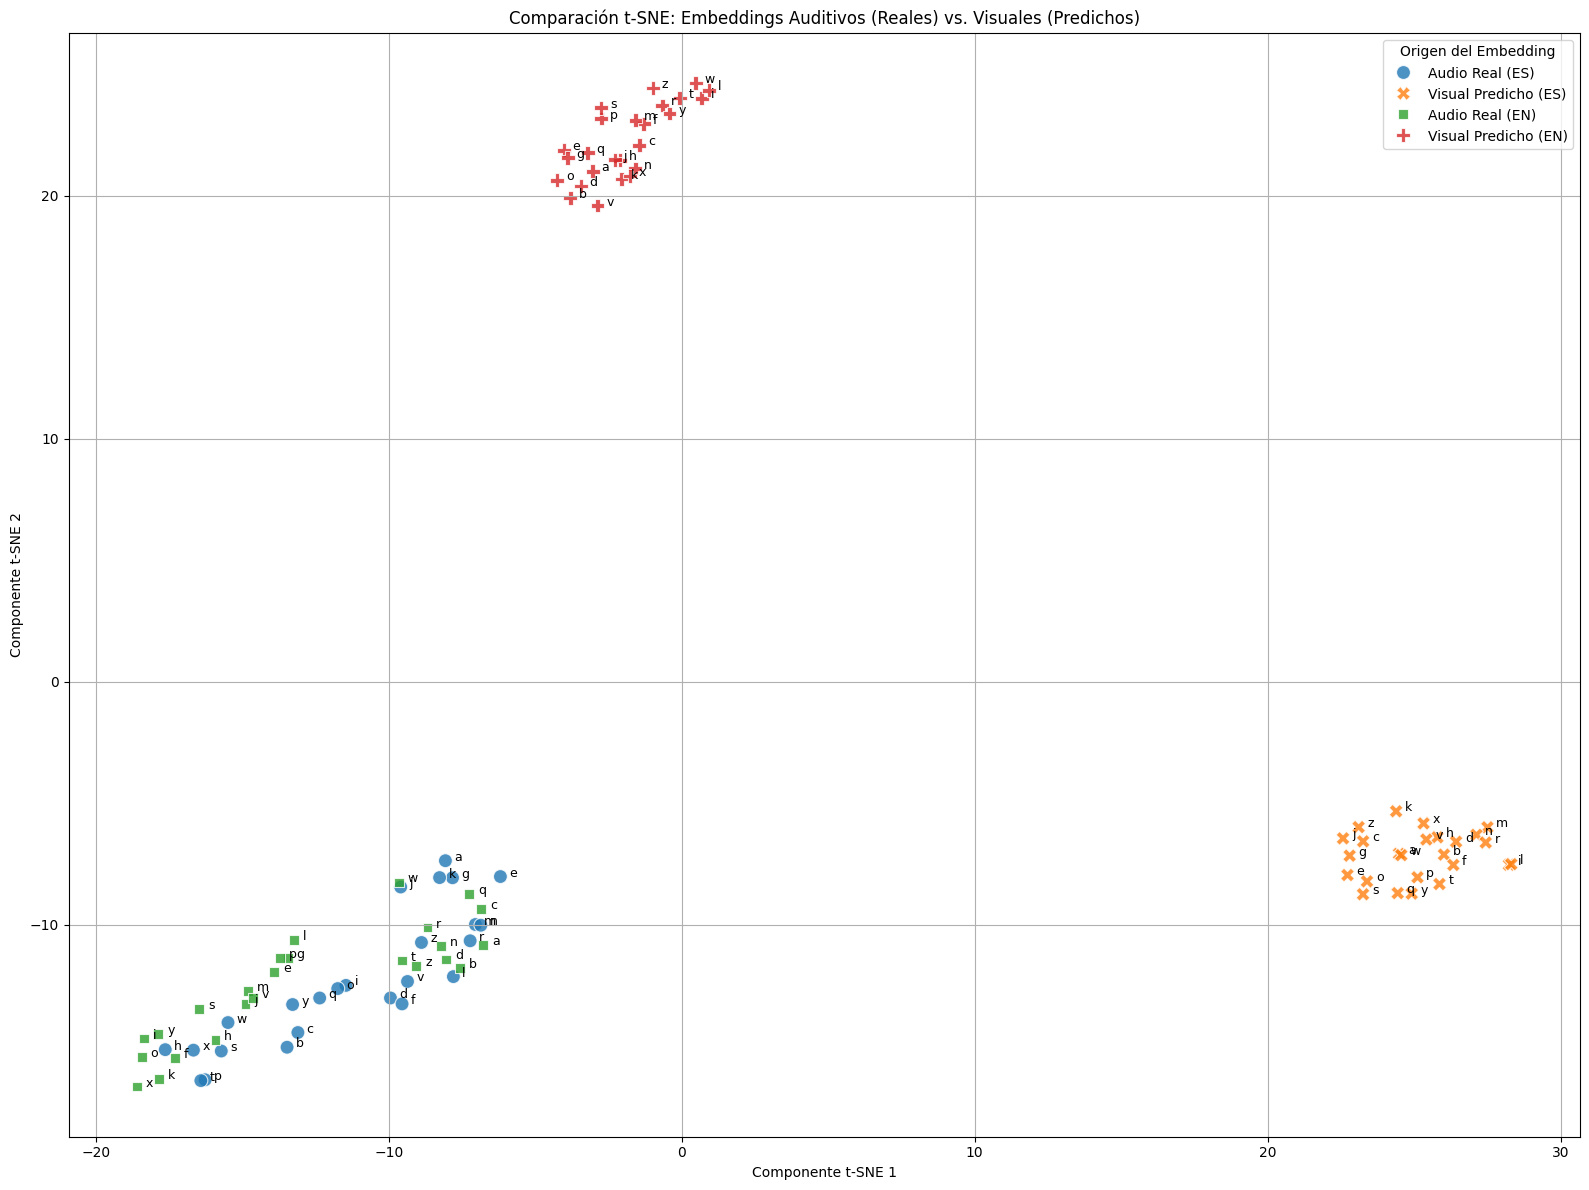

Gráfico t-SNE guardado en: /home/daniel/Proyectos/phonological-awareness/results/figures/visual_cornetZ_lstm_decoder_perceptual_v2_tsne_comparison.png


In [42]:
from sklearn.manifold import TSNE

# --- Preparar datos para el gráfico t-SNE fusionado ---
all_embeddings_avg = []
all_labels = []
all_sources = []

print("Preparando datos para la visualización t-SNE comparativa...")
transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for lang in LANGUAGES:
    if lang not in results_visual: continue

    image_dir = project_root / f"data/02_processed/grapheme_images_resized_{IMAGE_SIZE}/{lang}"
    embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    
    eval_dataset = GraphemeDataset(image_dir, embedding_dir, transform=transform_eval)
    eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual_with_labels)
    
    common_graphemes = eval_dataset.labels

    # 1. Cargar embeddings REALES de audio y promediarlos
    for label in common_graphemes:
        embedding_seq = np.load(embedding_dir / f"{label}.npy")
        all_embeddings_avg.append(embedding_seq.mean(axis=0))
        all_labels.append(label)
        all_sources.append(f'Audio Real ({lang.upper()})')
        
    # 2. Generar embeddings PREDICHOS de la vía visual y promediarlos
    visual_model = results_visual[lang]['model']
    visual_model.eval()
    
    predictions_by_label = {label: [] for label in common_graphemes}
    with torch.no_grad():
        for images, target_embeddings, batch_labels in eval_loader:
            predicted_seqs = visual_model(images.to(device), target_embeddings.to(device))
            predicted_avg = predicted_seqs.mean(dim=1).cpu().numpy()
            
            for j, label in enumerate(batch_labels):
                predictions_by_label[label].append(predicted_avg[j])

    for label in common_graphemes:
        if predictions_by_label[label]:
            avg_pred = np.mean(predictions_by_label[label], axis=0)
            all_embeddings_avg.append(avg_pred)
            all_labels.append(label)
            all_sources.append(f'Visual Predicho ({lang.upper()})')

# --- Calcular y Graficar t-SNE ---
embedding_matrix = np.array(all_embeddings_avg)
print("\nCalculando proyección t-SNE... Esto puede tardar.")
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(embedding_matrix)

tsne_df = pd.DataFrame({'tsne-1': embeddings_2d[:, 0], 'tsne-2': embeddings_2d[:, 1], 'grapheme': all_labels, 'source': all_sources})

plt.figure(figsize=(16, 12))
sns.scatterplot(x="tsne-1", y="tsne-2", hue="source", style="source", data=tsne_df, s=100, alpha=0.8)

for i, row in tsne_df.iterrows():
    plt.text(row['tsne-1']+0.3, row['tsne-2'], row['grapheme'], fontsize=9)

plt.title('Comparación t-SNE: Embeddings Auditivos (Reales) vs. Visuales (Predichos)')
plt.xlabel('Componente t-SNE 1'); plt.ylabel('Componente t-SNE 2'); plt.grid(True)
plt.legend(title='Origen del Embedding')
plt.tight_layout()

tsne_path = figure_dir / f"visual_{MODEL_ARCHITECTURE}_tsne_comparison.png"
plt.savefig(tsne_path)
plt.show()
print(f"Gráfico t-SNE guardado en: {tsne_path}")

### **Paso 7: Evaluación Cuantitativa y Guardado de Métricas**

Esta es la prueba de fuego final. Usamos los embeddings "imaginados" por la vía visual como entrada para el clasificador auditivo y medimos su rendimiento.

1.  **Matrices de Confusión**: Muestran los aciertos y errores de clasificación. Una diagonal fuerte indica un buen rendimiento.
2.  **Heatmaps de Logits**: Visualizan la "confianza" del clasificador para cada clase. Un patrón similar al de los datos reales indica una alta fidelidad de la representación.
3.  **Tabla de Métricas**: Calculamos Accuracy, Precisión, Recall y F1-Score para cuantificar el rendimiento y lo guardamos en un archivo `.csv` para su posterior análisis.



--- Evaluación Cuantitativa para: ES ---
Dataset creado con 1250 imágenes de 25 grafemas comunes.

--- Evaluación Cuantitativa para: EN ---
Dataset creado con 1250 imágenes de 25 grafemas comunes.


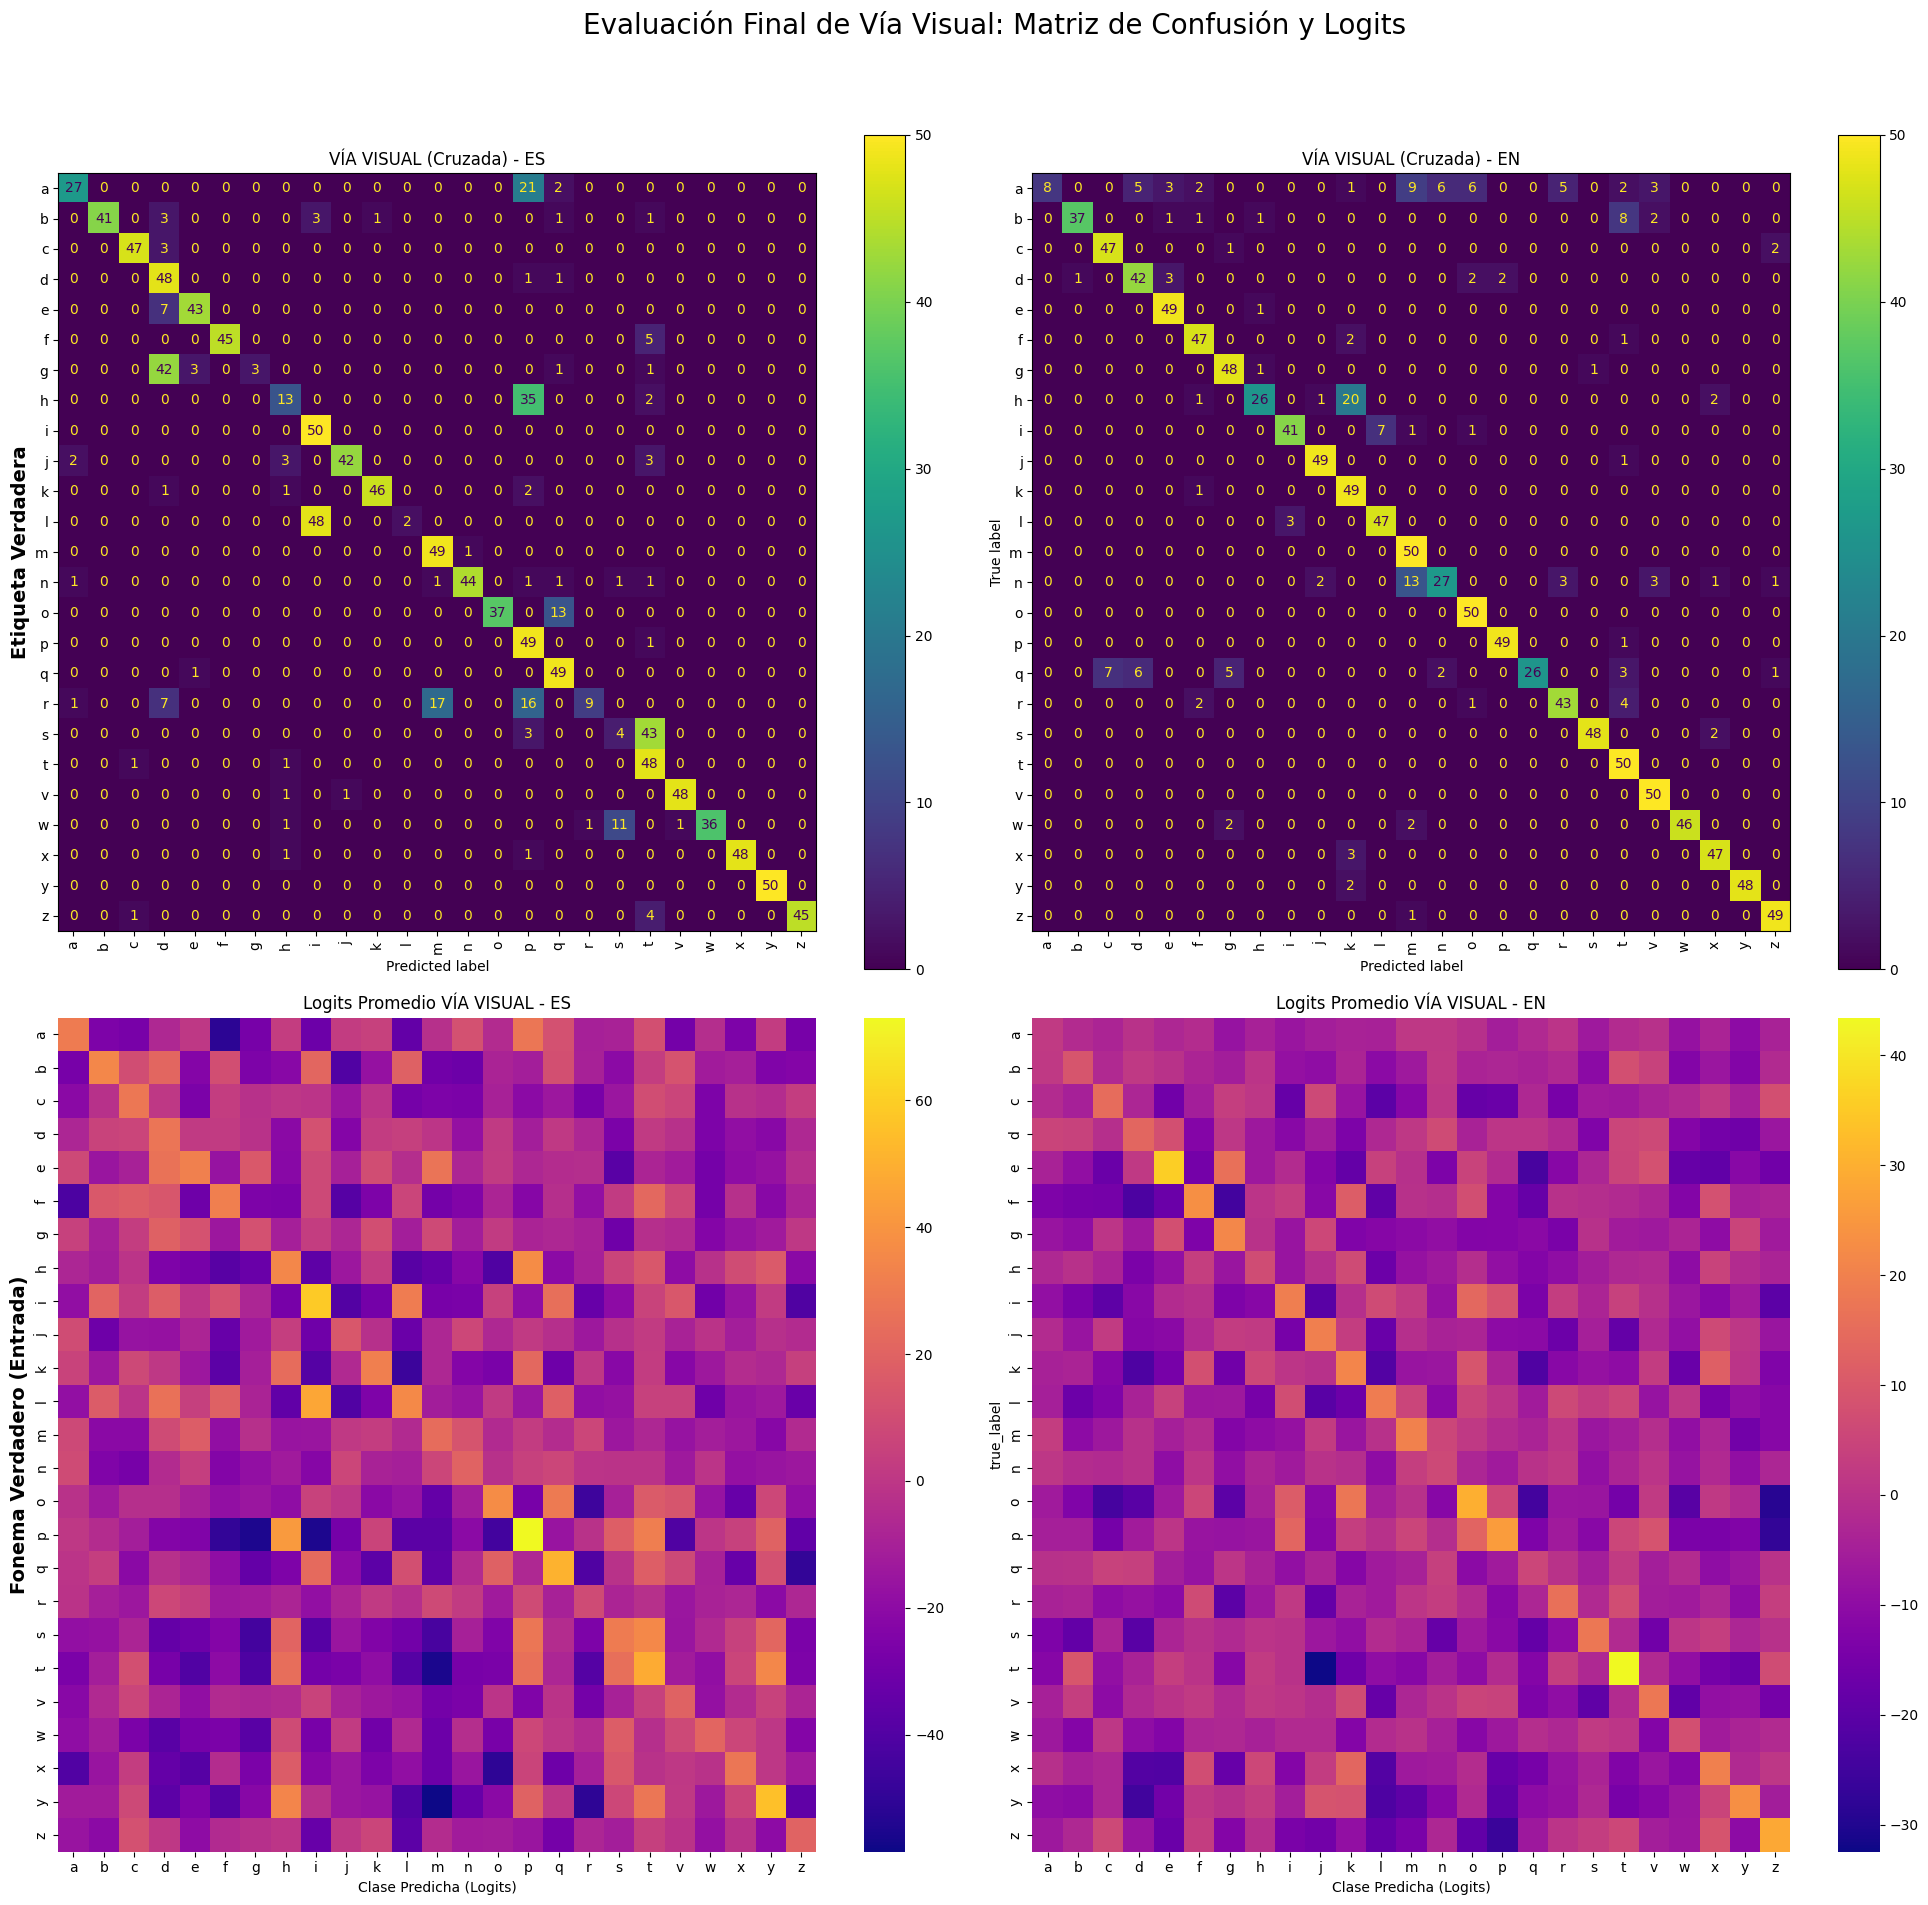

Gráficos de evaluación guardados en: /home/daniel/Proyectos/phonological-awareness/results/figures/visual_cornetZ_lstm_decoder_perceptual_v2_evaluation_plots.png

--- Tabla de Métricas de Clasificación (Vía Visual -> Auditiva) ---
  language                               model  accuracy  precision_weighted  recall_weighted  f1_weighted
0       es  cornetZ_lstm_decoder_perceptual_v2    0.7384            0.825062           0.7384     0.710764
1       en  cornetZ_lstm_decoder_perceptual_v2    0.8584            0.878693           0.8584     0.844839

Tabla de métricas guardada en: /home/daniel/Proyectos/phonological-awareness/results/tables/visual_cornetZ_lstm_decoder_perceptual_v2_metrics.csv


In [43]:
# --- Celda de Evaluación Final y Generación de Métricas ---

# MODIFICADO: Se ajusta el figsize y se elimina gridspec_kw para un tamaño más equilibrado.
fig, axes = plt.subplots(2, len(LANGUAGES), figsize=(20, 20)) 
if len(LANGUAGES) == 1: axes = axes.reshape(2, 1)

for i, lang in enumerate(LANGUAGES):
    print(f"\n--- Evaluación Cuantitativa para: {lang.upper()} ---")
    if lang not in results_visual: continue
        
    # --- Carga de modelos y datos ---
    image_dir = project_root / f"data/02_processed/grapheme_images_resized_{IMAGE_SIZE}/{lang}"
    embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    auditory_model_path = model_dir / f"{lang}_auditory_cnn1d_comparative.pth"
    
    full_dataset_lang = GraphemeDataset(image_dir, embedding_dir, transform=transform_eval)
    loader_lang = DataLoader(full_dataset_lang, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual_with_labels)
    
    display_labels = full_dataset_lang.labels
    label_to_int = {label: i for i, label in enumerate(display_labels)}
    
    all_auditory_labels = sorted([p.stem for p in embedding_dir.glob("*.npy")])
    num_total_auditory_classes = len(all_auditory_labels)
    auditory_cnn = PhonemeCNN(num_classes=num_total_auditory_classes).to(device)
    auditory_cnn.load_state_dict(torch.load(auditory_model_path, map_location=device))
    auditory_cnn.eval()

    visual_model = results_visual[lang]['model']
    visual_model.eval()
    
    # --- Generación de predicciones ---
    true_labels_text_list, pred_indices_cross, logits_cross_list = [], [], []
    with torch.no_grad():
        for images, target_embeddings, true_labels_text in loader_lang:
            predicted_embeddings = visual_model(images.to(device), target_embeddings.to(device))
            outputs = auditory_cnn(predicted_embeddings)
            _, predicted_indices = torch.max(outputs.data, 1)
            logits_cross_list.append(outputs.cpu().numpy())
            pred_indices_cross.extend(predicted_indices.cpu().numpy())
            true_labels_text_list.extend(true_labels_text)

    # --- Mapeo y cálculo de métricas ---
    int_to_all_labels = {i: label for i, label in enumerate(all_auditory_labels)}
    pred_labels_text = [int_to_all_labels[idx] for idx in pred_indices_cross]
    true_indices_filtered = [label_to_int[lbl] for lbl in true_labels_text_list]
    pred_indices_filtered = [label_to_int.get(lbl, -1) for lbl in pred_labels_text]
    
    accuracy = accuracy_score(true_indices_filtered, pred_indices_filtered)
    precision, recall, f1, _ = precision_recall_fscore_support(true_indices_filtered, pred_indices_filtered, average='weighted', zero_division=0)
    
    evaluation_metrics.append({
        'language': lang,
        'model': MODEL_ARCHITECTURE,
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1
    })
    
    # --- Gráficos ---
    ax_cm = axes[0, i]
    cm_cross = confusion_matrix(true_indices_filtered, pred_indices_filtered, labels=range(len(display_labels)))
    disp_cross = ConfusionMatrixDisplay(confusion_matrix=cm_cross, display_labels=display_labels)
    
    # MODIFICADO: Se cambia el colormap a 'viridis'
    disp_cross.plot(ax=ax_cm, xticks_rotation='vertical', cmap='viridis')
    ax_cm.set_title(f'VÍA VISUAL (Cruzada) - {lang.upper()}')

    ax_logits = axes[1, i]
    logits_cross = np.vstack(logits_cross_list)
    indices_of_interest = [all_auditory_labels.index(lbl) for lbl in display_labels]
    filtered_logits = logits_cross[:, indices_of_interest]
    
    logits_df = pd.DataFrame(filtered_logits, columns=display_labels)
    logits_df['true_label'] = true_labels_text_list
    
    mean_logits_df = logits_df.groupby('true_label').mean().sort_index()
    
    # MODIFICADO: Se cambia el colormap a 'plasma'
    sns.heatmap(
        mean_logits_df,
        xticklabels=True,
        yticklabels=True,
        ax=ax_logits,
        cmap='plasma' 
    )
    ax_logits.set_title(f'Logits Promedio VÍA VISUAL - {lang.upper()}')
    ax_logits.set_xlabel('Clase Predicha (Logits)');

axes[0, 0].set_ylabel('Etiqueta Verdadera', fontsize=14, weight='bold')
axes[1, 0].set_ylabel('Fonema Verdadero (Entrada)', fontsize=14, weight='bold')
fig.suptitle('Evaluación Final de Vía Visual: Matriz de Confusión y Logits', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

eval_figure_path = figure_dir / f"visual_{MODEL_ARCHITECTURE}_evaluation_plots.png"
plt.savefig(eval_figure_path)
plt.show()
print(f"Gráficos de evaluación guardados en: {eval_figure_path}")

# --- Guardado de Métricas en CSV ---
metrics_df = pd.DataFrame(evaluation_metrics)
metrics_path = results_dir / f"visual_{MODEL_ARCHITECTURE}_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)

print("\n--- Tabla de Métricas de Clasificación (Vía Visual -> Auditiva) ---")
print(metrics_df.iloc[[0, 1]].to_string())
print(f"\nTabla de métricas guardada en: {metrics_path}")

## Paso 3: Visualizaciones Comparativas y Guardado

Una vez entrenados los modelos, comparamos sus curvas de aprendizaje y su rendimiento final en la métrica de similitud coseno.

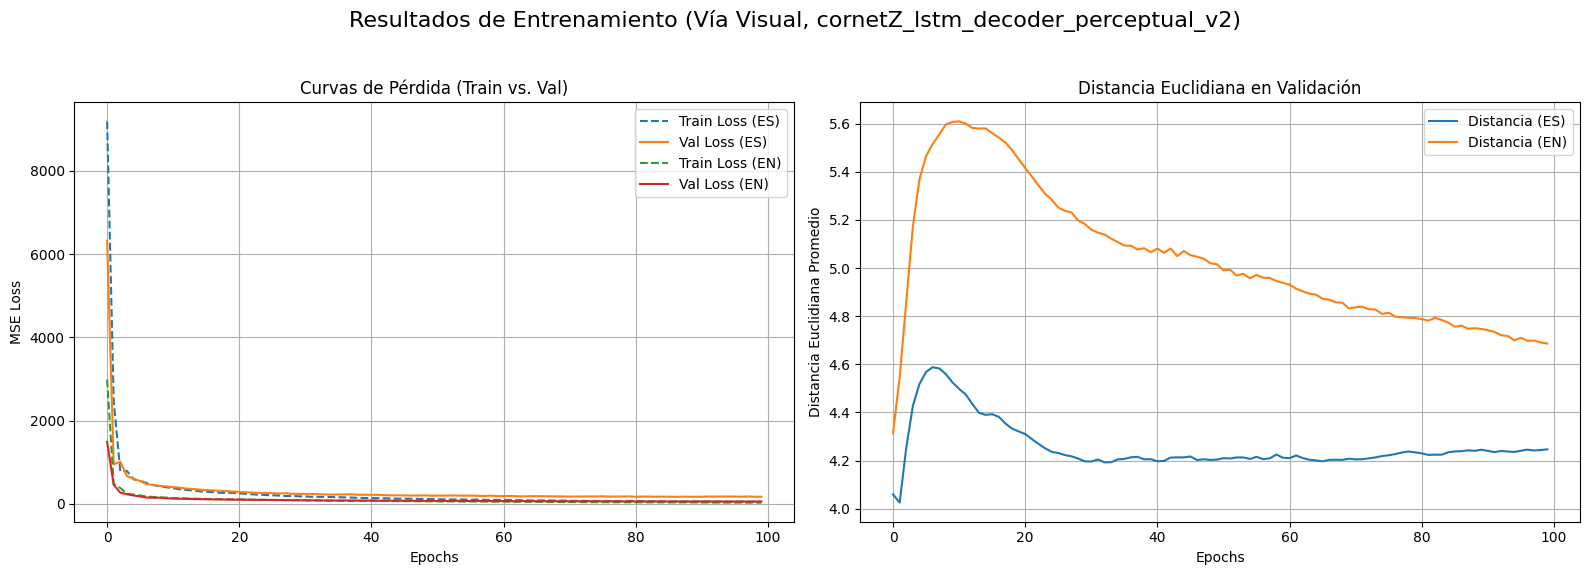

Curvas de aprendizaje guardadas en: /home/daniel/Proyectos/phonological-awareness/results/figures/comparative_visual_cornetZ_lstm_decoder_perceptual_v2_learning_curves.png
Modelo para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_visual_cornetZ_lstm_decoder_perceptual_v2.pth
Modelo para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_visual_cornetZ_lstm_decoder_perceptual_v2.pth


In [44]:
# --- Guardar Curvas de Aprendizaje ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for lang in LANGUAGES:
    ax1.plot(results_visual[lang]['history']['train_loss'], label=f'Train Loss ({lang.upper()})', linestyle='--')
    ax1.plot(results_visual[lang]['history']['val_loss'], label=f'Val Loss ({lang.upper()})')
ax1.set_title('Curvas de Pérdida (Train vs. Val)')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('MSE Loss'); ax1.legend(); ax1.grid(True)

for lang in LANGUAGES:
    ax2.plot(results_visual[lang]['history']['val_euclidean_dist'], label=f'Distancia ({lang.upper()})')
ax2.set_title('Distancia Euclidiana en Validación')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Distancia Euclidiana Promedio'); ax2.legend(); ax2.grid(True)

fig.suptitle(f'Resultados de Entrenamiento (Vía Visual, {MODEL_ARCHITECTURE})', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
visual_learning_curves_path = figure_dir / f"comparative_visual_{MODEL_ARCHITECTURE}_learning_curves.png"
plt.savefig(visual_learning_curves_path)
plt.show()
print(f"Curvas de aprendizaje guardadas en: {visual_learning_curves_path}")

# --- Guardar los modelos entrenados ---
for lang in LANGUAGES:
    model_visual = results_visual[lang]['model']
    model_visual_path = model_dir / f"{lang}_visual_{MODEL_ARCHITECTURE}.pth"
    torch.save(model_visual.state_dict(), model_visual_path)
    print(f"Modelo para '{lang}' guardado en: {model_visual_path}")

---
### **Paso 8: Conclusión**

Este notebook ha demostrado la viabilidad de entrenar una red neuronal para generar representaciones auditivas a partir de estímulos puramente visuales. El uso de una **pérdida perceptual** fue clave para alinear los objetivos de la red generativa con los del clasificador final, superando las limitaciones de una pérdida de reconstrucción simple como el MSE.

Los resultados, visualizados en las matrices de confusión, heatmaps de logits y el gráfico t-SNE, junto con las métricas cuantitativas, validan que el modelo `VisualToAuditoryModel` ha aprendido a capturar la "esencia" fonológica de los grafemas, emulando un aspecto fundamental de la conciencia fonológica.